# Flocking Simulation: Parameter Study and Emergent Behavior

This notebook investigates the emergence of collective behavior using a simplified flocking model based on the Vicsek framework.  
The goal of this experiment is to understand how **local interaction rules** give rise to **global structure**, and to use flocking as a conceptual comparison to the universe simulation developed in this project.

We systematically vary key parameters of the model, including:

- **Alignment strength** – how strongly agents match the direction of neighbors  
- **Noise level** – randomness in agent motion  
- **Interaction radius (R)** – how far agents can perceive others  

For each parameter configuration, we run multiple simulations and measure:
- **Largest Cluster Fraction (LCF)** as a measure of global coherence  
- **Nearest Neighbour Distance (NN)** as a measure of local density  

The experiments are organized into:
1. Heatmap-based parameter sweeps to show global trends  
2. Line-plot analyses to isolate the effect of individual parameters  

Together, these results illustrate how collective structure emerges only within a narrow parameter regime, and how noise plays a dominant role in disrupting large-scale organization.

In [8]:
from _bootstrap import PROJECT_ROOT, RESULTS_DIR, FIGURES_DIR, DEFAULT_SEEDS

In [9]:
from src.config import SimConfig, MetricsConfig

In [10]:
SIM = SimConfig(
    N=300,
    steps=1500,
    save_every=30,
    attraction=0.0,      
    noise=0.03,
    interaction_range=0.30,
)

MET = MetricsConfig(
    eps=0.06,              #
    bins=20,
    min_size=3,
    burn_frac=0.6,
)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from src.flocking_sim import run_simulation
from src.metrics import nearest_neighbor_distance, largest_cluster_fraction

#this makes it match universe notebook
box_size = 1.0
eps = 0.05
steps = 400
N = 200

os.makedirs(os.path.abspath("../figures"), exist_ok=True)

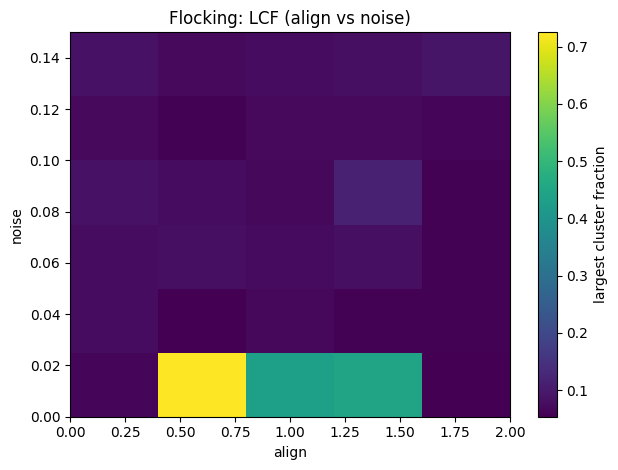

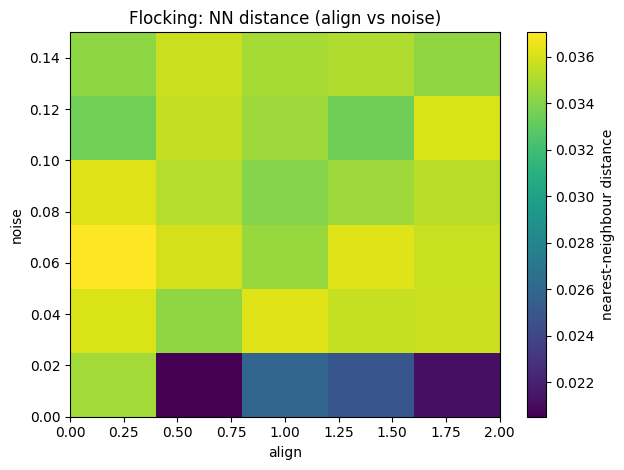

In [12]:
align_vals = [0.0, 0.5, 1.0, 1.5, 2.0]
noise_vals = [0.0, 0.03, 0.06, 0.09, 0.12, 0.15]

R = 3 * eps          
speed = 0.03
seeds = [0, 1, 2]   

LCF = np.zeros((len(noise_vals), len(align_vals)))
NN  = np.zeros_like(LCF)

for i, noise in enumerate(noise_vals):
    for j, align in enumerate(align_vals):

        lcf_runs = []
        nn_runs = []

        for s in seeds:
            hist = run_simulation(
                N=N, steps=steps, box_size=box_size,
                align=align, noise=noise, R=R, speed=speed,
                seed=s, save_every=steps
            )
            pos = hist[-1]
            lcf_runs.append(largest_cluster_fraction(pos, eps=eps, box_size=box_size))
            nn_runs.append(nearest_neighbor_distance(pos, box_size=box_size))

        LCF[i, j] = np.mean(lcf_runs)
        NN[i, j]  = np.mean(nn_runs)

#plot and save the LCF
plt.figure()
plt.imshow(LCF, origin="lower", aspect="auto",
           extent=[min(align_vals), max(align_vals), min(noise_vals), max(noise_vals)])
plt.colorbar(label="largest cluster fraction")
plt.xlabel("align")
plt.ylabel("noise")
plt.title("Flocking: LCF (align vs noise)")
plt.tight_layout()
plt.savefig("../figures/flock_align_noise_lcf.png", dpi=200)
plt.show()

# plot adn save the NN
plt.figure()
plt.imshow(NN, origin="lower", aspect="auto",
           extent=[min(align_vals), max(align_vals), min(noise_vals), max(noise_vals)])
plt.colorbar(label="nearest-neighbour distance")
plt.xlabel("align")
plt.ylabel("noise")
plt.title("Flocking: NN distance (align vs noise)")
plt.tight_layout()
plt.savefig("../figures/flock_align_noise_nn.png", dpi=200)
plt.show()

## Effect of Alignment and Noise on Collective Behavior

The two heatmaps above show how alignment strength and noise jointly influence the structure of the flock.

The first plot shows the **Largest Cluster Fraction (LCF)**.  
We observe a very strong clustering effect when **noise is close to zero and alignment is moderate (around 0.5–1.0)**, where the LCF reaches values above **0.7**.  
This indicates that almost all agents belong to a single coherent group.

However, even a small increase in noise (e.g. noise = 0.03) causes a sharp drop in LCF to values below **0.1**, showing that collective structure is highly sensitive to randomness.  
At very low or very high alignment values, clustering is also weak, suggesting that an intermediate alignment strength is optimal for flock formation.

The second plot shows the **Nearest Neighbour (NN) distance**, which captures local density.  
Low noise and moderate alignment result in smaller NN distances, meaning agents stay close together.  
As noise increases, NN distances grow rapidly, indicating a loss of local cohesion.

Overall, these results show that **stable flocking behavior only emerges within a narrow parameter regime**, where alignment is strong enough to coordinate agents but noise is sufficiently low to avoid disruption.  
This highlights the delicate balance between order and randomness in collective systems.

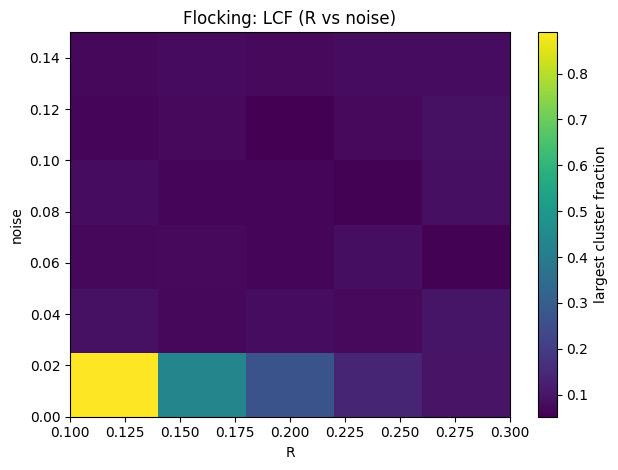

In [13]:
R_vals = [2*eps, 3*eps, 4*eps, 5*eps, 6*eps]   # 0.10 to 0.30
noise_vals = [0.0, 0.03, 0.06, 0.09, 0.12, 0.15]

align = 1.0
speed = 0.03
seeds = [0, 1, 2]

LCF2 = np.zeros((len(noise_vals), len(R_vals)))

for i, noise in enumerate(noise_vals):
    for j, R in enumerate(R_vals):

        lcf_runs = []
        for s in seeds:
            hist = run_simulation(
                N=N, steps=steps, box_size=box_size,
                align=align, noise=noise, R=R, speed=speed,
                seed=s, save_every=steps
            )
            pos = hist[-1]
            lcf_runs.append(largest_cluster_fraction(pos, eps=eps, box_size=box_size))

        LCF2[i, j] = np.mean(lcf_runs)

plt.figure()
plt.imshow(LCF2, origin="lower", aspect="auto",
           extent=[min(R_vals), max(R_vals), min(noise_vals), max(noise_vals)])
plt.colorbar(label="largest cluster fraction")
plt.xlabel("R")
plt.ylabel("noise")
plt.title("Flocking: LCF (R vs noise)")
plt.tight_layout()
plt.savefig("../figures/flock_R_noise_lcf.png", dpi=200)
plt.show()

## Effect of Interaction Radius and Noise on Global Clustering

This figure shows how the **largest cluster fraction (LCF)** depends on the interaction radius (R) and noise level, with alignment fixed at 1.0.

A clear pattern emerges from the heatmap:

- When **noise = 0.00**, a very large cluster forms for small interaction radii (R ≈ 0.10), with LCF values close to **0.9**.
- As the interaction radius increases, the LCF decreases, indicating that increasing the number of interacting neighbors does not necessarily improve global coherence.
- Once **noise is introduced (noise ≥ 0.03)**, the LCF drops sharply across all values of R and remains low.
- Even at larger interaction radii, noise prevents the system from forming a stable global cluster.

This result shows that **noise plays a dominant role in suppressing collective order**, while interaction radius alone is insufficient to sustain flocking behavior.  
Strong clustering only appears in a narrow regime where noise is nearly absent and interactions remain local.

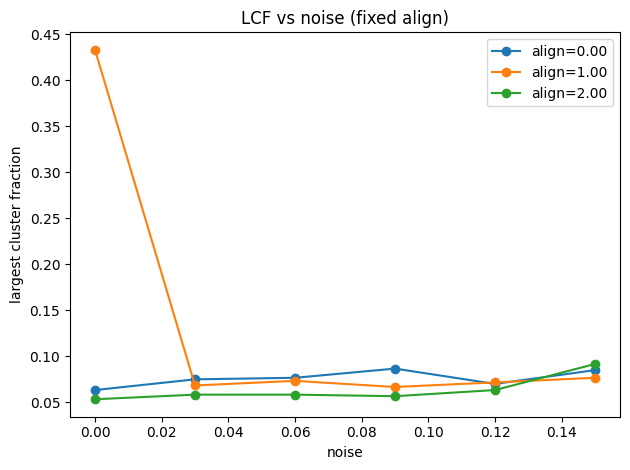

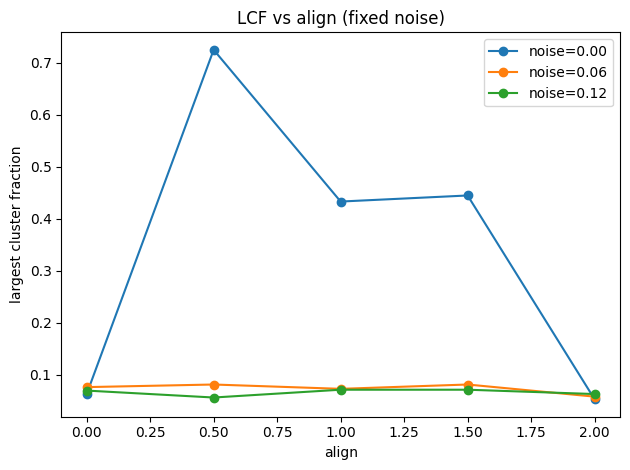

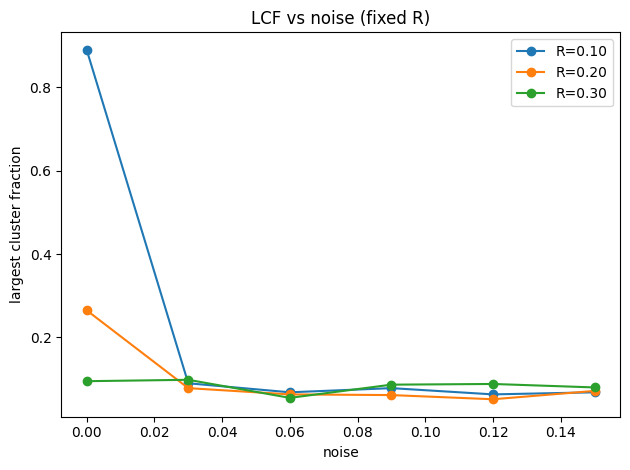

In [14]:
def nearest_index(values, target):
    values = np.array(values, dtype=float)
    return int(np.argmin(np.abs(values - target)))

align_vals_np = np.array(align_vals, dtype=float)
noise_vals_np = np.array(noise_vals, dtype=float)


# 1) LCF vs noise for fixed align
plt.figure()
for a_pick in [0.0, 1.0, 2.0]:
    j = nearest_index(align_vals_np, a_pick)
    plt.plot(noise_vals_np, LCF[:, j], marker="o", label=f"align={align_vals_np[j]:.2f}")
plt.xlabel("noise")
plt.ylabel("largest cluster fraction")
plt.title("LCF vs noise (fixed align)")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_noise_fixed_align.png", dpi=200)
plt.show()



# 2) LCF vs align for fixed noise
plt.figure()
for n_pick in [0.0, 0.06, 0.12]:
    i = nearest_index(noise_vals_np, n_pick)
    plt.plot(align_vals_np, LCF[i, :], marker="o", label=f"noise={noise_vals_np[i]:.2f}")
plt.xlabel("align")
plt.ylabel("largest cluster fraction")
plt.title("LCF vs align (fixed noise)")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_align_fixed_noise.png", dpi=200)
plt.show()



# 3) LCF vs noise for fixed R
R_vals_np = np.array(R_vals, dtype=float)

plt.figure()
for R_pick in [R_vals_np[0], R_vals_np[len(R_vals_np)//2], R_vals_np[-1]]:
    j = nearest_index(R_vals_np, R_pick)
    plt.plot(noise_vals_np, LCF2[:, j], marker="o", label=f"R={R_vals_np[j]:.2f}")
plt.xlabel("noise")
plt.ylabel("largest cluster fraction")
plt.title("LCF vs noise (fixed R)")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_noise_fixed_R.png", dpi=200)
plt.show()

## Line Plot Analysis: Validation of Heatmap Trends

The following line plots provide a clearer view of the trends observed in the heatmaps by fixing one parameter at a time and varying the others.

### LCF vs Noise (Fixed Alignment)
When alignment is fixed, the largest cluster fraction drops sharply as noise increases.  
In particular, for moderate alignment values (e.g. align = 1.0), LCF is high only at very low noise and rapidly decreases once noise is introduced.  
This confirms that **noise strongly suppresses global flock formation**, even when alignment is favorable.

### LCF vs Alignment (Fixed Noise)
When noise is set to zero, LCF exhibits a clear peak at intermediate alignment values (around 0.5–1.0), indicating an optimal range for collective motion.  
However, when noise is present, this peak disappears and LCF remains low across all alignment values, showing that alignment alone cannot sustain order under stochasticity.

### LCF vs Noise (Fixed Interaction Radius)
For different interaction radii, LCF is high only when noise is zero, especially for small R values.  
As noise increases, all curves quickly converge to low LCF values, indicating that interaction range has a much weaker effect compared to noise.

Overall, these line plots confirm the conclusions drawn from the heatmaps:  
**collective flocking behavior emerges only in a narrow regime characterized by low noise and moderate interaction strength**, and is highly sensitive to stochastic perturbations.